## Topic: Sentiment Analysis on Conversational Data
Import required packages

In [61]:
import os
import re
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import floor
from collections import Counter
from tqdm import tqdm, tqdm_notebook
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer, SnowballStemmer

In [62]:
from sklearn.utils import shuffle
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, f1_score, roc_curve

In [63]:
from keras.layers import Input, Dense, Embedding, Conv1D, Conv2D, Lambda, LSTM, ConvLSTM2D, TimeDistributed, Masking, Bidirectional
from keras.layers import Reshape, Flatten, Dropout, Concatenate, Activation, MaxPooling1D, GlobalAveragePooling1D, MaxPooling2D, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence
from keras.models import Model, load_model, Sequential
from keras.optimizers import Adam
from keras.regularizers import l2, l1
from keras.utils import to_categorical
from keras import optimizers
import keras.backend as K

## Data Import

In [64]:
dev_raw = pd.read_csv(os.path.join(os.getcwd(), 'data','dev_sent_emo.csv'))
train_raw = pd.read_csv(os.path.join(os.getcwd(), 'data','train_sent_emo.csv'))
test_raw = pd.read_csv(os.path.join(os.getcwd(), 'data','test_sent_emo.csv'))

In [65]:
dev_raw.head()

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,1,"Oh my God, hes lost it. Hes totally lost it.",Phoebe,sadness,negative,0,0,4,7,"00:20:57,256","00:21:00,049"
1,2,What?,Monica,surprise,negative,0,1,4,7,"00:21:01,927","00:21:03,261"
2,3,"Or! Or, we could go to the bank, close our acc...",Ross,neutral,neutral,1,0,4,4,"00:12:24,660","00:12:30,915"
3,4,Youre a genius!,Chandler,joy,positive,1,1,4,4,"00:12:32,334","00:12:33,960"
4,5,"Aww, man, now we wont be bank buddies!",Joey,sadness,negative,1,2,4,4,"00:12:34,211","00:12:37,505"


## Labels Distribution

Text(0.5, 1.0, 'testing set')

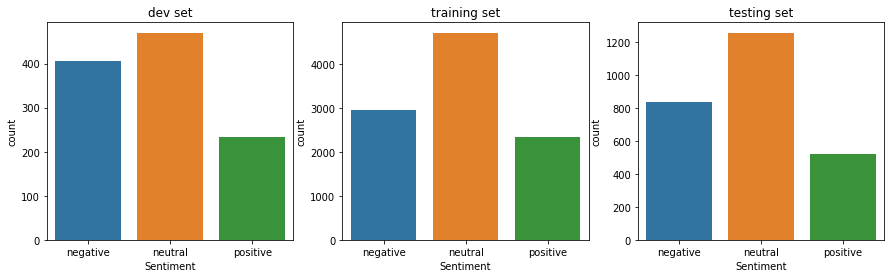

In [66]:
f, axes = plt.subplots(1, 3, figsize=(15,4))
sns.countplot(x='Sentiment', data=dev_raw, ax=axes[0], order=['negative','neutral','positive']).set_title('dev set')
sns.countplot(x='Sentiment', data=train_raw, ax=axes[1], order=['negative','neutral','positive']).set_title('training set')
sns.countplot(x='Sentiment', data=test_raw, ax=axes[2], order=['negative','neutral','positive']).set_title('testing set')

In [67]:
print(Counter(dev_raw.Sentiment))
print(Counter(train_raw.Sentiment))
print(Counter(test_raw.Sentiment))

Counter({'neutral': 470, 'negative': 406, 'positive': 233})
Counter({'neutral': 4710, 'negative': 2945, 'positive': 2334})
Counter({'neutral': 1256, 'negative': 833, 'positive': 521})


In [68]:
dev_raw.Utterance = dev_raw.Utterance.apply(lambda x: re.sub('\\x92', "'", x))
train_raw.Utterance = train_raw.Utterance.apply(lambda x: re.sub('\\x92', "'", x))
test_raw.Utterance = test_raw.Utterance.apply(lambda x: re.sub('\\x92', "'", x))

Text(0.5, 1.0, 'train+test set')

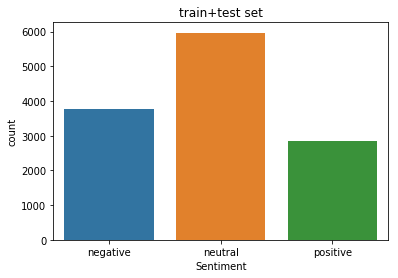

In [69]:
train_raw['source'] = 'train'
test_raw['source'] = 'test'
data_raw = pd.concat([train_raw, test_raw])
data_raw.shape
sns.countplot(x='Sentiment', data=data_raw, order=['negative','neutral','positive']).set_title('train+test set')

## Resampling  
To deal with imbalanced datasets.

In [70]:
count_neutral, count_negative, count_positive = data_raw.Sentiment.value_counts()
print(f'There are {count_negative} negative, {count_neutral} neutral and {count_positive} positive utternaces.')

There are 3778 negative, 5966 neutral and 2855 positive utternaces.


In [71]:
tmp_df_negative = data_raw[data_raw.Sentiment == 'negative']
tmp_df_neutral = data_raw[data_raw.Sentiment == 'neutral']
tmp_df_positive = data_raw[data_raw.Sentiment == 'positive']

tmp_df_negative_undersampled = tmp_df_negative.sample(floor(count_positive*1.1)).reset_index(drop=True)
tmp_df_neutral_undersampled = tmp_df_neutral.sample(floor(count_positive*0.95)).reset_index(drop=True)

In [72]:
data_balanced = pd.concat([tmp_df_negative_undersampled, tmp_df_neutral_undersampled, tmp_df_positive], axis=0)
data_balanced = shuffle(data_balanced)
data_balanced.head()

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime,source
1932,6710,"Hey, this isn't like swimming after you eat, p...",Chandler,anger,negative,664,4,3,15,"00:16:52,886","00:16:57,223",train
3668,3873,Ooh!,Phoebe,joy,positive,392,4,4,23,"0:17:52,807","0:17:53,009",train
7737,8148,That's right! You lose sucker!! Please still ...,Monica,joy,positive,819,18,7,4,"00:07:05,967","00:07:12,889",train
813,2132,Why do have a picture of Paulette in your pack?!,Richard,anger,negative,210,4,7,23,"00:18:24,311","00:18:27,814",train
1108,7330,"Ross, thank you. Hey, do you guys wanna go see...",Rachel,neutral,neutral,733,3,6,1,"00:20:44,076","00:20:48,621",train


There are 3140 negative, 2712 neutral and 2855 positive utternaces.


Text(0.5, 1.0, 'rebalanced set')

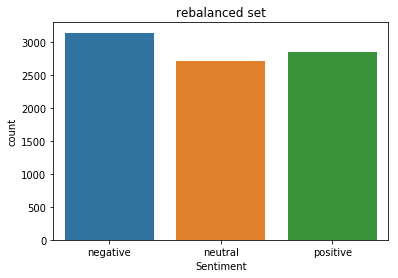

In [73]:
new_c_negative, new_c_positive, new_c_neutral = data_balanced.Sentiment.value_counts()
print(f'There are {new_c_negative} negative, {new_c_neutral} neutral and {new_c_positive} positive utternaces.')
sns.countplot(x='Sentiment', data=data_balanced, order=['negative','neutral','positive']).set_title('rebalanced set')

In [74]:
print(f'Ratio: {round(100*new_c_negative/len(data_balanced),0)}% negative, {round(100*new_c_neutral/len(data_balanced),0)}% neutral and {round(100*new_c_positive/len(data_balanced),0)}% positive utternaces.')

Ratio: 36.0% negative, 31.0% neutral and 33.0% positive utternaces.


## Word Count Distribution
Remove punctuations & special symbols

In [80]:
unwanted_pattern = r'[^A-z0-9\s]'
data_balanced['text'] = data_balanced.Utterance.apply(lambda u: re.sub(unwanted_pattern, '', u))

In [83]:
data_balanced[['Utterance', 'text']].head()

,Utterance,text
1932,"Hey, this isn't like swimming after you eat, p...",Hey this isnt like swimming after you eat pick...
3668,Ooh!,Ooh
7737,That's right! You lose sucker!! Please still ...,Thats right You lose sucker Please still marr...
813,Why do have a picture of Paulette in your pack?!,Why do have a picture of Paulette in your pack
1108,"Ross, thank you. Hey, do you guys wanna go see...",Ross thank you Hey do you guys wanna go see a ...


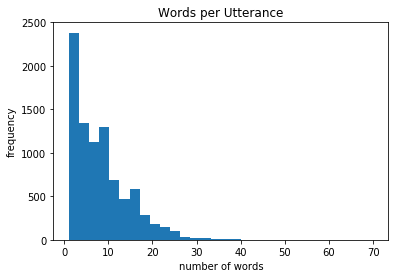

In [101]:
word_count = [len(t.split(' ')) for t in data_balanced.text]
plt.hist(word_count, bins=30, range=[1,70])
plt.title('Words per Utterance')
plt.ylabel('frequency')
plt.xlabel('number of words')
plt.show()

In [100]:
print(f"On average the dataset has {round(sum(word_count)/len(word_count))} words per utterance.")

On average the dataset has 8 words per utterance.


## Lemmatisation

In [16]:
import nltk
nltk.download('punkt')
porter = PorterStemmer()
snowball = SnowballStemmer("english")

def stemSentence(sentence, stemmer):
    token_words=word_tokenize(sentence)
    token_words
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(porter.stem(word))
    return " ".join(stem_sentence)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [14]:
utterances = data_balanced.Utterance.values
utterances_stem = [stemSentence(sentence, snowball) for sentence in utterances]

## Preprocessing (deep learning)

In [18]:
print('The longest utterance contains {} words.'.format(max([len(x.split(' ')) for x in data_balanced.Utterance])))

The longest utterance contains 69 words.


In [19]:
# For sentiment analysis
num_polarities = 3
max_sequence_len = 100

vocabulary_size = 6000
tokenizer = Tokenizer(num_words= vocabulary_size, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{}~', lower=True, )
tokenizer.fit_on_texts(utterances_stem)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 4185 unique tokens.


In [20]:
X = tokenizer.texts_to_sequences(utterances_stem)
X = pad_sequences(X, maxlen=max_sequence_len)
print('Shape of data tensor:', X.shape)

# X = tokenizer.texts_to_matrix(data_balanced.Utterance, mode='tfidf')
# print('Shape of data tensor:', X.shape)
# X[0]

Shape of data tensor: (8707, 100)


In [21]:
y = data_balanced.Sentiment.values
sen_targets, sen_uniques = pd.factorize(y, sort=True)
y = to_categorical(sen_targets, num_polarities)

In [22]:
sen_label_map = dict(zip(list(sen_uniques), range(num_polarities)))
sen_label_map

{'negative': 0, 'neutral': 1, 'positive': 2}

In [23]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

## Preprocessing (supervised learning)  
To avoid naming conflict, the x_train, y_train used in supervised learning will be represented by p_train, q_train

In [15]:
num_polarities=3
P = utterances_stem
Q = data_balanced.Sentiment.values

q, uniques = pd.factorize(Q, sort=True)
label_map = dict(zip(list(uniques), range(num_polarities)))
label_map

{'negative': 0, 'neutral': 1, 'positive': 2}

### TF-IDF Tokenizer

In [33]:
tfidf = TfidfVectorizer(lowercase=True, stop_words='english', ngram_range=(1,3))
tfidf.fit(P)
p = tfidf.transform(P)

### Truncated SVD  
To reduce the dimension of the features

In [41]:
def plot_svd(n_comp_list, data):
    var_explained=[]
    for n in n_comp_list:
        svd = TruncatedSVD(n_components=n)
        svd.fit(data)
        var_explained.append(svd.explained_variance_ratio_.sum())
    plt.plot(n_comp_list, var_explained)
    plt.ylabel('variance explained')
    plt.xlabel('number of components')
    plt.title('Selecting n_components')
    plt.grid(True)
    plt.show()

Sometimes, var_explained >= 0.9 or var_explained >= 0.95 reduces how many variables you need going forward in your analysis.

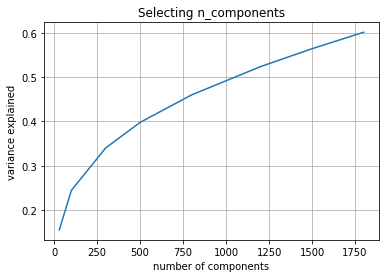

In [27]:
plot_svd(n_comp_list=[30,100,300,500,800,1200,1500,1800], data=p)

In [24]:
svd = TruncatedSVD(n_components=500)
p_svd = svd.fit_transform(p)

## Factory functions
### Cross-validation with Stratified K-fold

In [31]:
def predict_with_cv(clf, X, y, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, random_state=42)
    acc_collector=[]
    nth_fold = 0
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        clf.fit(X=X_train, y=y_train)
        y_pred = clf.predict(X_test)
        acc = round(100*np.sum(y_pred==y_test)/len(y_pred),2)
        nth_fold += 1
        acc_collector.append(acc)
        print('Fold {}: F1 score = {}; Test ccuracy = {}%'.format(
            nth_fold, f1_score(y_pred=y_pred, y_true=y_test, average="weighted"), acc))
    print('Average accuracy over {} folds is {}%'.format(n_splits, sum(acc_collector)/len(acc_collector)))

### Ploting deep learning val_loss against epoch

In [29]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('epoch')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('epoch')
    plt.legend()

## Models  
**Summary on Sentiment Analysis**  
Predicting 3 classes: Positive, Negative & Neutral   
  
**Models ready at disposal:**  
- SVM  
- Random Forest
- Fully connected (Dense only)  
- CNN  
- Transfer learning with Glove + LSTM

**Accuracy records** 
- Benchmart(Base): 36.06%
- SVM: 49.63%  
- Random Forest: 47.33%
- Dense: 36.88%
- CNN: 38.03%  
- LSTM (with Glove): 42%  

*NB: there might be a ceiling on how much you can achieve with the data*

### Baseline
A simplest model that will predict the same class for any given sentences/utterances.

In [50]:
class BaseModel():
    def __init__(self):
        self.pred=None
        
    def fit(self, X, y):
        self.pred = Counter(y).most_common()[0][0]
        
    def predict(self, x_test):
        return x_test.shape[0] * [self.pred]

In [45]:
base_model = BaseModel()
predict_with_cv(base_model, X=p, y=q, n_splits=5)

Fold 1: F1 score = 0.19105252704345846; Test ccuracy = 36.05%
Fold 2: F1 score = 0.19105252704345846; Test ccuracy = 36.05%
Fold 3: F1 score = 0.19124295750999717; Test ccuracy = 36.07%
Fold 4: F1 score = 0.19124295750999717; Test ccuracy = 36.07%
Fold 5: F1 score = 0.19124295750999717; Test ccuracy = 36.07%
Average accuracy over 5 folds is 36.062%


/Users/cheuky/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Support Vector Machine (SVM)

In [27]:
svm = SVC(C=10, kernel='linear', probability=True, random_state=42)

In [29]:
# param_grid_svm = { 
#     'C': [1,10,100], 'kernel': ['linear', 'rbf']
# }
# clf = GridSearchCV(estimator=svm, param_grid=param_grid_svm, cv=5)
# clf.fit(x_train_tr, y_train)

In [ ]:
# clf.best_estimator_

**Best model by GridSearchCV**  
SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,  
decision_function_shape='ovr', degree=3, gamma='auto_deprecated',  
kernel='linear', max_iter=-1, probability=True, random_state=None,  
shrinking=True, tol=0.001, verbose=False)

In [51]:
# svm_accuracy = 100*np.sum(y_pred_svm==q_test)/len(y_pred_svm)
# print('Test accuracy: %.4f%%' % svm_accuracy)

In [30]:
predict_with_cv(svm, X=p_svd, y=q, n_splits=5)

Fold 1: F1 score = 0.4962186249534722; Test ccuracy = 50.34%
Fold 2: F1 score = 0.4782719839250737; Test ccuracy = 48.22%
Fold 3: F1 score = 0.4815661531107952; Test ccuracy = 48.48%
Fold 4: F1 score = 0.47462396054127426; Test ccuracy = 48.08%
Fold 5: F1 score = 0.48492597308789737; Test ccuracy = 48.94%
Average accuracy over 5 folds is 48.812%


__SVD n_components=300:__  
Fold 1: F1 score = 0.4803915716898258; Test ccuracy = 48.91%  
Fold 2: F1 score = 0.4542740225417006; Test ccuracy = 46.84%  
Fold 3: F1 score = 0.48864408148921173; Test ccuracy = 49.91%  
Fold 4: F1 score = 0.4892975093190058; Test ccuracy = 50.32%  
Fold 5: F1 score = 0.4784412899435637; Test ccuracy = 49.22%  
Average accuracy over 5 folds is 49.04%  
  
__SVD n_components=500:__  
Fold 1: F1 score = 0.49002215752622763; Test ccuracy = 49.77%  
Fold 2: F1 score = 0.4808583429948203; Test ccuracy = 49.2%  
Fold 3: F1 score = 0.4874187290127619; Test ccuracy = 49.34%  
Fold 4: F1 score = 0.4944249992907478; Test ccuracy = 50.03%  
Fold 5: F1 score = 0.4919448080783031; Test ccuracy = 49.8%  
Average accuracy over 5 folds is 49.628%  
  
__SVD n_components=800:__  
Fold 1: F1 score = 0.46966213004635426; Test ccuracy = 47.3%  
Fold 2: F1 score = 0.4711375764871562; Test ccuracy = 47.65%  
Fold 3: F1 score = 0.4928203326071507; Test ccuracy = 49.74%  
Fold 4: F1 score = 0.4823228281974452; Test ccuracy = 48.54%  
Fold 5: F1 score = 0.4761281720634562; Test ccuracy = 48.02%  
Average accuracy over 5 folds is 48.25%  

### Random Forest

In [28]:
rf = RandomForestClassifier(n_estimators=100, min_samples_leaf=4, min_samples_split=4,
                            criterion='gini', max_features='auto')

In [29]:
predict_with_cv(clf=rf, X=p_svd, y=q, n_splits=5)

Fold 1: F1 score = 0.47461706544641874; Test ccuracy = 48.97%
Fold 2: F1 score = 0.456600241551185; Test ccuracy = 46.44%
Fold 3: F1 score = 0.4523886385518907; Test ccuracy = 46.3%
Fold 4: F1 score = 0.4738436999013484; Test ccuracy = 48.71%
Fold 5: F1 score = 0.48235998563306615; Test ccuracy = 48.77%
Average accuracy over 5 folds is 47.838%


__SVD n_components=300:__  
Fold 1: F1 score = 0.4821594130439804; Test ccuracy = 49.02%  
Fold 2: F1 score = 0.4457256160906289; Test ccuracy = 45.52%  
Fold 3: F1 score = 0.4799812863744916; Test ccuracy = 48.59%  
Fold 4: F1 score = 0.4742767830904166; Test ccuracy = 48.42%  
Fold 5: F1 score = 0.4626270907058054; Test ccuracy = 47.33%  
Average accuracy over 5 folds is 47.78%  
  
__SVD n_components=500:__  
Fold 1: F1 score = 0.4563487257822179; Test ccuracy = 46.84%  
Fold 2: F1 score = 0.47949307279503584; Test ccuracy = 49.31%  
Fold 3: F1 score = 0.48139907627684986; Test ccuracy = 49.28%  
Fold 4: F1 score = 0.4600893431558319; Test ccuracy = 47.04%  
Fold 5: F1 score = 0.4569176293258227; Test ccuracy = 47.04%  
Average accuracy over 5 folds is 47.902%  
  
__SVD n_components=800:__  
Fold 1: F1 score = 0.47376694097558875; Test ccuracy = 48.39%  
Fold 2: F1 score = 0.4360728461345362; Test ccuracy = 44.72%  
Fold 3: F1 score = 0.4658015840886764; Test ccuracy = 47.33%  
Fold 4: F1 score = 0.46356914367324187; Test ccuracy = 47.73%  
Fold 5: F1 score = 0.44157950564388676; Test ccuracy = 45.61%  
Average accuracy over 5 folds is 46.76%  

In [52]:
# param_grid_rf = { 
#     'n_estimators': [1,10,100],
#     'min_samples_split': [2, 4],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['auto', 'sqrt']
# }
# clf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5)
# clf.fit(p_train, q_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [1, 10, 100], 'min_samples_split': [2, 4], 'min_samples_leaf': [1, 2, 4], 'max_features': ['auto', 'sqrt']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [33]:
# clf.best_estimator_

**Best model by GridSearchCV**  
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',  
            max_depth=None, max_features='auto', max_leaf_nodes=None,  
            min_impurity_decrease=0.0, min_impurity_split=None,  
            min_samples_leaf=4, min_samples_split=4,  
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,  
            oob_score=False, random_state=None, verbose=0,  
            warm_start=False)

In [52]:
# rf.fit(X=p_train, y=q_train)
# y_pred_rf = rf.predict(p_test)
# f1_score(y_pred=y_pred_rf, y_true=q_test, average="weighted")
# rf_accuracy = 100*np.sum(y_pred_rf==q_test)/len(y_pred_rf)
# print('Test accuracy: %.4f%%' % rf_accuracy)

### Keras TF-IDF tokenizer + Neural nets

Neural network won't accept sentences with different dimension(i.e. number of words) as input. By padding the inputs, we decide the maximum length of words in a sentence, then zero pads the rest, if the input length is shorter than the designated length. In the case where it exceeds the maximum length, then it will also truncate either from the beginning or from the end.  
*Ref_1* https://keras.io/preprocessing/sequence/  
*Ref_2* https://towardsdatascience.com/another-twitter-sentiment-analysis-with-python-part-11-cnn-word2vec-41f5e28eda74

https://medium.com/@sabber/classifying-yelp-review-comments-using-lstm-and-word-embeddings-part-1-eb2275e4066b
#### Dense - Fully Connected Layers

__Early Stopping__: Often, the first sign of no further improvement may not be the best time to stop training. This is because the model may coast into a plateau of no improvement or even get slightly worse before getting much better.

We can account for this by adding a delay to the trigger in terms of the number of epochs on which we would like to see no improvement. This can be done by setting the “patience” argument.

In [24]:
dense_epochs=100
dense_checkpts = ModelCheckpoint(filepath=os.path.join(os.getcwd(),'saved_models','text','dense.weights.best.hdf5'), 
                               verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [25]:
def build_dense(num_classes, show=True):
    dense = Sequential()
    dense.add(Dense(32, activation='relu', input_dim=max_sequence_len))
    dense.add(Dropout(0.2))
    dense.add(Dense(64, activation='relu'))
    dense.add(BatchNormalization())
    dense.add(Dense(128, activation='relu'))
    dense.add(BatchNormalization())
    dense.add(Dense(num_classes, activation='softmax'))
    dense.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    if show:
        print(dense.summary())
    return dense

In [26]:
dense = build_dense(num_polarities)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                3232      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320      
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 387       
Total para

The validation_split is a value between 0 and 1 and defines the percentage amount of the training dataset to use for the validation dataset.

In [27]:
dense_history=dense.fit(x_train, y_train, validation_split=0.4, epochs=dense_epochs, callbacks=[dense_checkpts, es], verbose=1)

Train on 3499 samples, validate on 2334 samples
Epoch 1/100
3499/3499 [==============================] - 3s 876us/step - loss: 1.2716 - acc: 0.3444 - val_loss: 1.1472 - val_acc: 0.3526
Epoch 2/100
3499/3499 [==============================] - 1s 310us/step - loss: 1.1820 - acc: 0.3447 - val_loss: 1.1354 - val_acc: 0.3436
Epoch 3/100
3499/3499 [==============================] - 1s 294us/step - loss: 1.1631 - acc: 0.3492 - val_loss: 1.1417 - val_acc: 0.3470
Epoch 4/100
3499/3499 [==============================] - 1s 304us/step - loss: 1.1396 - acc: 0.3487 - val_loss: 1.1265 - val_acc: 0.3496
Epoch 5/100
3499/3499 [==============================] - 1s 303us/step - loss: 1.1215 - acc: 0.3701 - val_loss: 1.1207 - val_acc: 0.3483
Epoch 6/100
3499/3499 [==============================] - 1s 294us/step - loss: 1.1290 - acc: 0.3584 - val_loss: 1.1292 - val_acc: 0.3483
Epoch 7/100
3499/3499 [==============================] - 1s 322us/step - loss: 1.1202 - acc: 0.3641 - val_loss: 1.1088 - val_acc: 

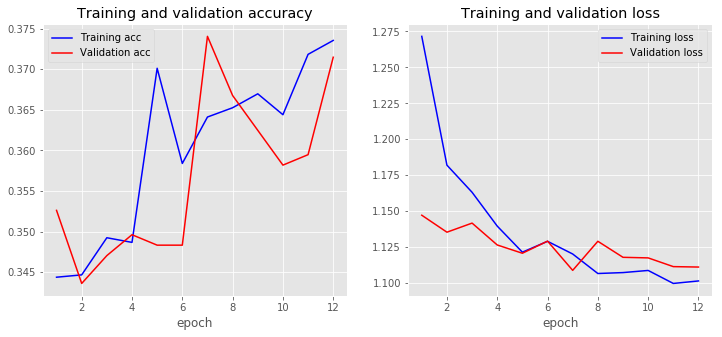

In [31]:
plot_history(dense_history)

Load the best weights saved during training

In [32]:
dense = build_dense(num_polarities, show=False)
dense.load_weights(os.path.join(os.getcwd(),'saved_models','text','dense.weights.best.hdf5'))

In [33]:
y_pred_dense = dense.predict_classes(x_test)
Counter(y_pred_dense)

2874/2874 [==============================] - 0s 76us/step


Counter({2: 1018, 0: 1664, 1: 192})

In [34]:
dense_accuracy = dense.evaluate(x_test, y_test, batch_size=128)[1] * 100
print('Test accuracy: %.4f%%' % dense_accuracy)

2874/2874 [==============================] - 0s 37us/step
Test accuracy: 36.8824%


__Note: About batch_size__  
Advantages of using a batch size < number of all samples:

- It requires less memory. Since you train the network using fewer samples, the overall training procedure requires less memory. That's especially important if you are not able to fit the whole dataset in your machine's memory.

- Typically networks train faster with mini-batches. That's because we update the weights after each propagation. In our example we've propagated 11 batches (10 of them had 100 samples and 1 had 50 samples) and after each of them we've updated our network's parameters. If we used all samples during propagation we would make only 1 update for the network's parameter.

Disadvantages of using a batch size < number of all samples:

- The smaller the batch the less accurate the estimate of the gradient will be.

### CNN - Convolutional Layers
**Conv1D:** is generally good for text, whereas Conv2D is good for audio and images where spatial matter;  

**Max pooling:** is a sample-based discretization process. The objective is to down-sample an input representation (image, hidden-layer output matrix, etc.), reducing it’s dimensionality and allowing for assumptions to be made about features contained in the sub-regions binned.  

**Batch Normalization:** normalization (shifting inputs to zero-mean and unit variance) is often used as a pre-processing step to make the data comparable across features. This therefore leads to higher learning rate and better speed.  

**Drop out:** Its a regularization functino that reduces/prevents overfitting, by normalizing some pixels to 0.

In [35]:
n_length = x_train.shape[0]
n_features = x_train.shape[1]

x_train_reshaped = x_train.reshape(n_length, n_features, 1)
x_test_reshaped = x_test.reshape(x_test.shape[0], n_features, 1)

In [36]:
cnn_epochs=60
cnn_checkpts = ModelCheckpoint(filepath=os.path.join(os.getcwd(), 'saved_models', 'text', 'cnn.weights.best.hdf5'), 
                               verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [37]:
def build_CNN(num_classes, show=True):
    cnn = Sequential()
    cnn.add(Conv1D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(max_sequence_len,1)))
    cnn.add(MaxPooling1D(pool_size=2))
    cnn.add(Conv1D(filters=32, kernel_size=2, padding='same', activation='relu', kernel_regularizer=l2(0.01)))
    cnn.add(MaxPooling1D(pool_size=2))
    cnn.add(Conv1D(filters=64, kernel_size=2, padding='same', activation='relu',kernel_regularizer=l2(0.01)))
    cnn.add(MaxPooling1D(pool_size=2))
    cnn.add(GlobalAveragePooling1D())
#     cnn.add(Flatten())
    cnn.add(Dense(128, kernel_regularizer=l2(0.01)))
    cnn.add(BatchNormalization())
    cnn.add(Activation('relu'))
    cnn.add(Dropout(0.2))
    cnn.add(Dense(num_classes, activation='softmax'))
    cnn.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    if show:
        print(cnn.summary())
    return cnn

In [38]:
cnn = build_CNN(num_polarities)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 100, 16)           48        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 16)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 50, 32)            1056      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 25, 32)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 25, 64)            4160      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 12, 64)            0         
_________________________________________________________________
global_average_pooling1d_1 ( (None, 64)                0         
__________

In [39]:
!rm './saved_models/text/cnn.weights.best.hdf5'
cnn_history=cnn.fit(x_train_reshaped, y_train, validation_split=0.4,
                    epochs=cnn_epochs, callbacks=[cnn_checkpts, es], verbose=1)

Train on 3499 samples, validate on 2334 samples
Epoch 1/60
3499/3499 [==============================] - 3s 967us/step - loss: 2.3004 - acc: 0.3378 - val_loss: 1.9294 - val_acc: 0.3638
Epoch 2/60
3499/3499 [==============================] - 1s 358us/step - loss: 1.8033 - acc: 0.3370 - val_loss: 1.6246 - val_acc: 0.3513
Epoch 3/60
3499/3499 [==============================] - 1s 363us/step - loss: 1.5928 - acc: 0.3430 - val_loss: 1.4942 - val_acc: 0.3663
Epoch 4/60
3499/3499 [==============================] - 1s 346us/step - loss: 1.4714 - acc: 0.3421 - val_loss: 1.4011 - val_acc: 0.3376
Epoch 5/60
3499/3499 [==============================] - 1s 350us/step - loss: 1.3780 - acc: 0.3487 - val_loss: 1.3232 - val_acc: 0.3590
Epoch 6/60
3499/3499 [==============================] - 1s 349us/step - loss: 1.3317 - acc: 0.3504 - val_loss: 1.2792 - val_acc: 0.3402
Epoch 7/60
3499/3499 [==============================] - 1s 349us/step - loss: 1.2695 - acc: 0.3555 - val_loss: 1.2448 - val_acc: 0.3376


Epoch 27/60
3499/3499 [==============================] - 1s 337us/step - loss: 1.1049 - acc: 0.3584 - val_loss: 1.1392 - val_acc: 0.3616
Epoch 28/60
3499/3499 [==============================] - 1s 337us/step - loss: 1.1039 - acc: 0.3607 - val_loss: 1.1113 - val_acc: 0.3479
Epoch 29/60
3499/3499 [==============================] - 1s 347us/step - loss: 1.1015 - acc: 0.3584 - val_loss: 1.1002 - val_acc: 0.3702
Epoch 30/60
3499/3499 [==============================] - 1s 338us/step - loss: 1.0970 - acc: 0.3678 - val_loss: 1.1037 - val_acc: 0.3590
Epoch 31/60
3499/3499 [==============================] - 1s 349us/step - loss: 1.0971 - acc: 0.3715 - val_loss: 1.0990 - val_acc: 0.3608
Epoch 32/60
3499/3499 [==============================] - 1s 339us/step - loss: 1.0960 - acc: 0.3735 - val_loss: 1.1077 - val_acc: 0.3565
Epoch 33/60
3499/3499 [==============================] - 1s 341us/step - loss: 1.0939 - acc: 0.3767 - val_loss: 1.1203 - val_acc: 0.3149
Epoch 34/60
3499/3499 [==================

Load the best model from save

In [40]:
cnn = build_CNN(num_polarities, show=False)
cnn.load_weights(os.path.join(os.getcwd(),'saved_models','text','cnn.weights.best.hdf5'))

In [41]:
y_pred_cnn = cnn.predict_classes(x_test_reshaped)
Counter(y_pred_cnn)

2874/2874 [==============================] - 0s 92us/step


Counter({2: 929, 0: 1941, 1: 4})

In [42]:
cnn_accuracy = cnn.evaluate(x_test_reshaped, y_test, batch_size=128)[1] * 100
print('Test accuracy: %.4f%%' % cnn_accuracy)

2874/2874 [==============================] - 0s 62us/step
Test accuracy: 38.0306%


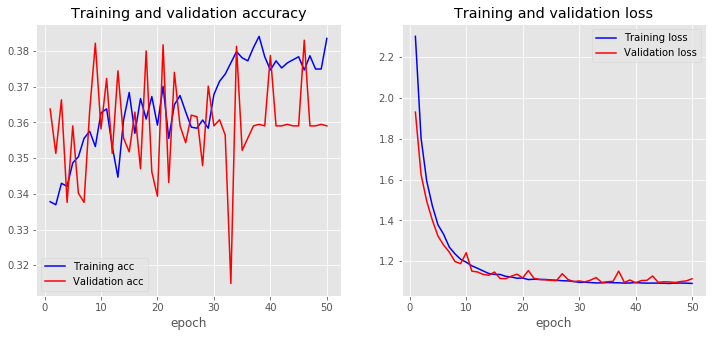

In [43]:
plot_history(cnn_history)

### GloVe

Extract word embeddings from the Glove

In [45]:
embeddings_index = dict()
f = open('glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

Create a weight matrix

In [46]:
# vocabulary_size=6000

embedding_matrix = np.zeros((vocabulary_size, max_sequence_len))
for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

### GloVe + LSTM

__Note1:__ Every LSTM layer should be accompanied by a Dropout layer. This layer will help to prevent overfitting by ignoring randomly selected neurons during training, and hence reduces the sensitivity to the specific weights of individual neurons.  
About Time Distributed layer: https://machinelearningmastery.com/timedistributed-layer-for-long-short-term-memory-networks-in-python/  A wrapper to wrap LSTM's output  
  
__Note2:__ To solve the problem of LSTM always predicting the same class even when trained with balanced data, the 'return_sequences' param in the LSTM layer needs to be set to True and add a Flatten layer. In addition, 'return_sequences=True' must be set when stacking LSTM layers so that the second LSTM layer has a three-dimensional sequence input

In [56]:
def build_ConvLSTM(num_classes, vocabulary_size=None, max_sequence_len=None, 
                   optimizer=None, use_glove=None, show=True):
    optimizer = optimizer or 'adam'
    use_glove = use_glove or True
    embedding_size=100
    lstm_output_size=128
    vocabulary_size=vocabulary_size or 6000
    max_sequence_len=100
    
    model = Sequential()
    if use_glove:
        model.add(Embedding(input_dim=vocabulary_size, output_dim=embedding_size, input_length=max_sequence_len,
                            weights=[embedding_matrix], trainable=False))
    else:
        model.add(Embedding(input_dim=vocabulary_size, output_dim=embedding_size, input_length=vocabulary_size))
    model.add(Conv1D(filters=64,
                     kernel_size=2,
                     padding='valid',
                     activation='relu',
                     kernel_regularizer=l2(0.01),
                     strides=1))
    model.add(MaxPooling1D(pool_size=4))
    model.add(LSTM(units=lstm_output_size, return_sequences=True))
    model.add(BatchNormalization())
    model.add(TimeDistributed(Dense(64)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=64, return_sequences=True))
    model.add(BatchNormalization())
    model.add(TimeDistributed(Dense(32)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=32, return_sequences=True))
    model.add(BatchNormalization())
    model.add(TimeDistributed(Dense(16)))
    model.add(Dropout(0.2))
#     model.add(Flatten())
    model.add(GlobalAveragePooling1D())
    model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    if show:
        print(model.summary())
    return model

In [57]:
glove_epochs=60
glove_checkpts = ModelCheckpoint(filepath=os.path.join(os.getcwd(), 'saved_models','text','glove.weights.best.hdf5'), 
                               verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=12)

In [58]:
glove = build_ConvLSTM(num_classes=num_polarities, vocabulary_size=vocabulary_size,
                           optimizer=optimizers.adam(lr=0.001), use_glove=True)
# glove = build_ConvLSTM(num_classes=num_polarities, vocabulary_size=vocabulary_size,
#                            optimizer='adam', use_glove=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          600000    
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 99, 64)            12864     
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 24, 64)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 24, 128)           98816     
_________________________________________________________________
batch_normalization_15 (Batc (None, 24, 128)           512       
_________________________________________________________________
time_distributed_7 (TimeDist (None, 24, 64)            8256      
_________________________________________________________________
dropout_13 (Dropout)         (None, 24, 64)            0         
__________

In [59]:
!rm './saved_models/text/glove.weights.best.hdf5'
glove_history=glove.fit(x_train, y_train, validation_split=0.4, epochs=glove_epochs, callbacks=[glove_checkpts, es], verbose=1)

rm: cannot remove './saved_models/text/glove.weights.best.hdf5': No such file or directory
Train on 3499 samples, validate on 2334 samples
Epoch 1/60
3499/3499 [==============================] - 18s 5ms/step - loss: 2.1584 - acc: 0.3487 - val_loss: 1.7770 - val_acc: 0.3590
Epoch 2/60
3499/3499 [==============================] - 16s 5ms/step - loss: 1.7609 - acc: 0.3598 - val_loss: 1.5487 - val_acc: 0.3290
Epoch 3/60
3499/3499 [==============================] - 16s 5ms/step - loss: 1.5243 - acc: 0.3495 - val_loss: 1.6267 - val_acc: 0.3269
Epoch 4/60
3499/3499 [==============================] - 16s 5ms/step - loss: 1.3810 - acc: 0.3584 - val_loss: 1.4206 - val_acc: 0.3269
Epoch 5/60
3499/3499 [==============================] - 16s 5ms/step - loss: 1.2867 - acc: 0.3672 - val_loss: 1.2732 - val_acc: 0.3269
Epoch 6/60
3499/3499 [==============================] - 16s 5ms/step - loss: 1.2345 - acc: 0.3770 - val_loss: 1.2890 - val_acc: 0.3582
Epoch 7/60
3499/3499 [=============================

Epoch 28/60
3499/3499 [==============================] - 16s 5ms/step - loss: 1.0843 - acc: 0.4284 - val_loss: 1.1424 - val_acc: 0.3685
Epoch 29/60
3499/3499 [==============================] - 16s 5ms/step - loss: 1.0822 - acc: 0.4341 - val_loss: 1.1015 - val_acc: 0.4040
Epoch 30/60
3499/3499 [==============================] - 16s 5ms/step - loss: 1.0826 - acc: 0.4330 - val_loss: 1.1224 - val_acc: 0.3608
Epoch 31/60
3499/3499 [==============================] - 16s 5ms/step - loss: 1.0750 - acc: 0.4393 - val_loss: 1.1246 - val_acc: 0.3732
Epoch 32/60
3499/3499 [==============================] - 16s 5ms/step - loss: 1.0779 - acc: 0.4324 - val_loss: 1.1067 - val_acc: 0.4019
Epoch 33/60
3499/3499 [==============================] - 16s 5ms/step - loss: 1.0738 - acc: 0.4424 - val_loss: 1.1039 - val_acc: 0.4019
Epoch 34/60
3499/3499 [==============================] - 16s 5ms/step - loss: 1.0745 - acc: 0.4378 - val_loss: 1.2567 - val_acc: 0.3638
Epoch 35/60
3499/3499 [=========================

Load the best model from save

In [60]:
glove = build_ConvLSTM(num_classes=num_polarities, vocabulary_size=vocabulary_size,
                           optimizer=optimizers.adam(lr=0.001), use_glove=True, show=False)
glove.load_weights(os.path.join(os.getcwd(),'saved_models','text','glove.weights.best.hdf5'))

In [61]:
y_pred_glove = glove.predict_classes(x_test)
Counter(y_pred_glove)

2874/2874 [==============================] - 4s 1ms/step


Counter({2: 1236, 0: 1577, 1: 61})

In [62]:
glove_accuracy = glove.evaluate(x_test, y_test, batch_size=128)[1] * 100
print('Test accuracy: %.4f%%' % glove_accuracy)

2874/2874 [==============================] - 2s 534us/step
Test accuracy: 41.9972%


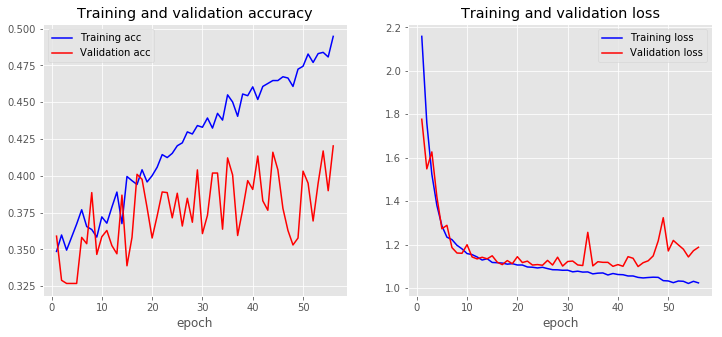

In [63]:
plot_history(glove_history)